# GPT Explainer

the purpose of this is to walk through what happens during the forward pass of GPT-2 like models.  To help display the transformation, we'll use the first sentence from the [linear algebra wiki page](https://en.wikipedia.org/wiki/Linear_algebra) and [lu decomposition wiki page](https://en.wikipedia.org/wiki/LU_decomposition) as the topic is fitting and it shows us some non-standard patterns.  

## Text Prep/Tokenization
we'll start with common preprocessing step of tokenizing the data.  This converts the string text into an array of numbers that can be used during the training loop.  I've built a very subtle byte-pair encdoing that has each unique character that appears and the top 5 merges. This keeps our vocab size small and managable for this example. Typically the vocab size is in the 100K+ range. A great library for this is `tiktoken`. Tokenization simply finds the longest pattern of characters that's in common with what was trained and replaces it with an integer that represents it.  This way we turn the text into a numeric array to simplify computing. 

In [1]:
import torch
from collections import Counter

In [2]:
class SimpleBPETokenizer:
    def __init__(self, num_merges=5, eot_token='<|endoftext|>'):
        self.num_merges = num_merges
        self.eot_token = eot_token
        self.eot_id = None
        self.merges = []
        self.pair_ranks = {}
        self.vocab = {}
        self.id_to_token = {}

    def _add_token(self, tok):
        if tok in self.vocab:
            return self.vocab[tok]
        i = len(self.vocab)
        self.vocab[tok] = i
        self.id_to_token[i] = tok
        return i

    def _get_bigrams(self, seq):
        for i in range(len(seq) - 1):
            yield (seq[i], seq[i + 1])

    def _merge_once(self, seq, pair):
        a, b = pair
        out = []
        i = 0
        while i < len(seq):
            if i < len(seq) - 1 and seq[i] == a and seq[i + 1] == b:
                out.append(a + b)
                i += 2
            else:
                out.append(seq[i])
                i += 1
        return out

    def train(self, corpus):
        # corpus: list[str]
        text = ''.join(corpus).lower()
        seq = list(text)
        merges = []
        for _ in range(self.num_merges):
            counts = Counter(self._get_bigrams(seq))
            if not counts: break
            best_pair, _ = counts.most_common(1)[0]
            merges.append(best_pair)
            seq = self._merge_once(seq, best_pair)
        self.merges = merges
        self.pair_ranks = {p: i for i, p in enumerate(self.merges)}

        self.vocab = {}
        self.id_to_token = {}
        for ch in sorted(set(text)):
            self._add_token(ch)
        for a, b in self.merges:
            self._add_token(a + b)
        self.eot_id = self._add_token(self.eot_token)

    def encode(self, text, force_last_eot=True):
        # treat literal eot marker as special; remove it from content
        if self.eot_token in text:
            text = text.replace(self.eot_token, '')
        seq = list(text)

        # make sure all seen base chars exist
        for ch in set(seq):
            if ch not in self.vocab:
                self._add_token(ch)

        # greedy BPE using learned pair ranks
        if self.merges:
            while True:
                best_pair, best_rank = None, None
                for p in self._get_bigrams(seq):
                    r = self.pair_ranks.get(p)
                    if r is not None and (best_rank is None or r < best_rank):
                        best_pair, best_rank = p, r
                if best_pair is None:
                    break
                seq = self._merge_once(seq, best_pair)

        # ensure all tokens in seq exist in vocab (e.g., if new chars appeared)
        for tok in seq:
            if tok not in self.vocab:
                self._add_token(tok)

        ids = [self.vocab[tok] for tok in seq]

        # FORCE: append EOT id if not already last
        if force_last_eot:
            if not ids or ids[-1] != self.eot_id:
                ids.append(self.eot_id)

        return ids

    def decode(self, ids):
        # drop trailing EOT if present
        if ids and self.eot_id is not None and ids[-1] == self.eot_id:
            ids = ids[:-1]
        toks = [self.id_to_token[i] for i in ids]
        return ''.join(toks)


In [3]:
raw_example_1 = r'''Linear algebra is central to almost all areas of mathematics. For instance, linear algebra is fundamental in modern presentations of geometry, including for defining basic objects such as lines, planes and rotations. Also, functional analysis, a branch of mathematical analysis, may be viewed as the application of linear algebra to function spaces.'''
raw_example_2 = r'''In numerical analysis and linear algebra, lower–upper (LU) decomposition or factorization factors a matrix as the product of a lower triangular matrix and an upper triangular matrix (see matrix multiplication and matrix decomposition).'''


In [4]:
tok = SimpleBPETokenizer(num_merges=5)
tok.train([raw_example_1,raw_example_2])
tok.merges

[(' ', 'a'), ('a', 't'), ('i', 'n'), (' ', 'm'), ('i', 'o')]

In [5]:
tok.vocab

{' ': 0,
 '(': 1,
 ')': 2,
 ',': 3,
 '.': 4,
 'a': 5,
 'b': 6,
 'c': 7,
 'd': 8,
 'e': 9,
 'f': 10,
 'g': 11,
 'h': 12,
 'i': 13,
 'j': 14,
 'l': 15,
 'm': 16,
 'n': 17,
 'o': 18,
 'p': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28,
 '–': 29,
 ' a': 30,
 'at': 31,
 'in': 32,
 ' m': 33,
 'io': 34,
 '<|endoftext|>': 35}

In [6]:
vocab_size = len(tok.vocab)
vocab_size

36

In [7]:
eot = tok.eot_id
tokens = []
for example in [raw_example_1, raw_example_2]:
    tokens.extend([eot])
    tokens.extend(tok.encode(example.lower()))
all_tokens = torch.tensor(tokens, dtype=torch.long)
all_tokens

tensor([35, 15, 32,  9,  5, 20, 30, 15, 11,  9,  6, 20,  5,  0, 13, 21,  0,  7,
         9, 17, 22, 20,  5, 15,  0, 22, 18, 30, 15, 16, 18, 21, 22, 30, 15, 15,
        30, 20,  9,  5, 21,  0, 18, 10, 33, 31, 12,  9, 16, 31, 13,  7, 21,  4,
         0, 10, 18, 20,  0, 32, 21, 22,  5, 17,  7,  9,  3,  0, 15, 32,  9,  5,
        20, 30, 15, 11,  9,  6, 20,  5,  0, 13, 21,  0, 10, 23, 17,  8,  5, 16,
         9, 17, 22,  5, 15,  0, 32, 33, 18,  8,  9, 20, 17,  0, 19, 20,  9, 21,
         9, 17, 22, 31, 34, 17, 21,  0, 18, 10,  0, 11,  9, 18, 16,  9, 22, 20,
        27,  3,  0, 32,  7, 15, 23,  8, 32, 11,  0, 10, 18, 20,  0,  8,  9, 10,
        32, 32, 11,  0,  6,  5, 21, 13,  7,  0, 18,  6, 14,  9,  7, 22, 21,  0,
        21, 23,  7, 12, 30, 21,  0, 15, 32,  9, 21,  3,  0, 19, 15,  5, 17,  9,
        21, 30, 17,  8,  0, 20, 18, 22, 31, 34, 17, 21,  4, 30, 15, 21, 18,  3,
         0, 10, 23, 17,  7, 22, 34, 17,  5, 15, 30, 17,  5, 15, 27, 21, 13, 21,
         3, 30,  0,  6, 20,  5, 17,  7, 

## Modeling
A machine learning model forward pass now uses the tokenization information, runs several layers of linear algebra on it, and then "predicts" the next token. When it is noisy (like you will see in this example), this process results in gibberish.  The training process changes the noise to pattern during the "backward pass" as you'll see.    We'll show 3 steps that are focused on training:
1. Data Loading - this step pulls from the raw data enough tokens to complete a forward and backward pass.  If the model is inference only, this step is replaces with taking in the inference input and preparing it similarly for only the forward pass.
2. Forward Pass - using the data and the model architecture to predict the next token
3. Backward Pass - using differentials to understand what parameters most impact the forward pass' impact on it's prediction, comparing that against what is actually right based on the data loading step, and then making very minor adjustments to the impactful parameters with the hope it improves future predictions.  

```
x, y = train_loader.next_batch()
logits, loss = model(x, y)
loss.backward()
```

### Data Loading
```
x, y = train_loader.next_batch()
```

To start, we need to get enough data to run the forward and backward passes.  Since our total dataset is likely too big to hold all at once in real practice, we would read just enough file information into memory so that we can run the passes, leaving memory and compute to be used on the passes instead of static data holding. 
To start, we have to identify the batch size and the model context length to determine how much data we need.  Consequentially, these dimensions also form 2 of the 3 dimensions in the initial matrix.
- **Batch Size (B)** - This is the number of examples you'll learn on at a time. 
- **Context Length (T)** - This is the max number of tokens that a model can use in a single pass to generat the next token. If an example is below this length, it can be padded.
  
*Ideally both B and T are multiples of 2 to work nicely with chip architecture. This is a common theme across the board*

In [8]:
B = 2 # Batch
T = 8 # context length

To start, we need to pull from our long raw_token list enough tokens for the forward pass. To be able to satisfy training `B` Batches `T` Context length, we need to pull out `B*T` tokens to slide the context window across the examples enough to satisfy the batch size.  Since the training will attempt to predict the last token given the previous tokens in context, we also need 1 more token at the end so that the last training example in the last batch can have the next token to validate against. 

In [9]:
current_position = 0
tok_for_training = all_tokens[current_position:current_position + B*T +1 ]
tok_for_training

tensor([35, 15, 32,  9,  5, 20, 30, 15, 11,  9,  6, 20,  5,  0, 13, 21,  0])

Now that we have our initial tokens to train on, we now need to convert it to a matrix that's ready for training. In this step we'll need to create our batches and setup two different arrays: 1/ the input, `x`, tokens that will result in 2/ the output `y` tokens. To create each example in the batch, every `T` tokens will be placed into it's own row. 

Recall that training takes in a string of tokens the length of the context and then predicts the next token. Recall that when we extracted `tok_for_training` we added 1 extra token so that we can evaluate the prediction for the last example. Bcause of this, the input, `x`, will be all of the tokens up to the second to last element `[:-1]`.  

It might be natural to think the output `y` would then just be the last token.But this is actually wasting valuable training loops.  Yes, there is the xample that fills the context `T`, but we also have enough tokens in `tok_for_training` where any context length of `n` where `n<T` can also be used for inference since we have the `n+1` token available.  You can think of the following example:

sentence: `Hi I am learning`. This sentence contains the following "next tokens" that can be learned:
1. x: Hi I am  | y: learning
2. x: Hi I     | y: am
3. x: Hi       | y: I

Because we have this triangle to create, our `y` can be much larger.  We can start with the second token and, go all the way to the last element we added for the last example `[1:'`.   


We will now put this together and do the following:
1. Extract the input `x` and then split it into an example for each batch `B`
2. Extract the output `y` and then split it into an example for each batch `B`

*Note: View can take `-1` which allows the matrix to infer the dimension so we do not need to pass in `T`, but given how many matricies we'll work with we want to make sure we're controlling the dimensions or erroring out if they do not match our expectations.*

In [10]:
tok_for_training

tensor([35, 15, 32,  9,  5, 20, 30, 15, 11,  9,  6, 20,  5,  0, 13, 21,  0])

In [11]:
x=tok_for_training[:-1].view(B, T)
x

tensor([[35, 15, 32,  9,  5, 20, 30, 15],
        [11,  9,  6, 20,  5,  0, 13, 21]])

In [12]:
y=tok_for_training[1:].view(B, T)
y

tensor([[15, 32,  9,  5, 20, 30, 15, 11],
        [ 9,  6, 20,  5,  0, 13, 21,  0]])

### Forward pass
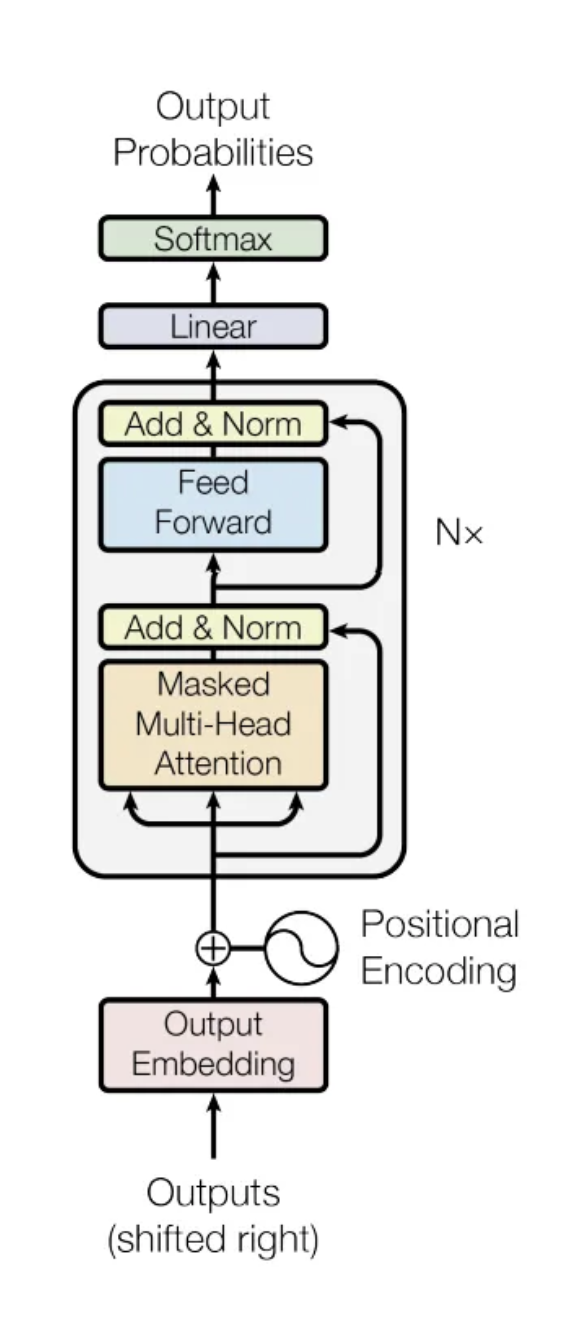

The forward pass takes a string of tokens in and predicts the next "n" tokens.  This step as we'll look at it is focused on training where we'll pass in the input `x`, carry that input through the layers, and generate a matrix of the probability of each token being the next one, something we call `logits`. During the forward pass at the end we then compare the probability to the actual next token in `y` and calculate `loss` based on the difference. 

We first rederive the batch size and context size based on the input. basing this on the input helps us create a more dynamic formula.  

In [13]:
import torch.nn as nn

In [14]:
B, T = x.size()
B,T

(2, 8)

The first layer of our network creates an embedding representation of our input sequence. 

In [15]:
block_size = 8 # max sequence length/context
vocab_size = vocab_size # 36 
n_embd = 4 # 

### Input Layer
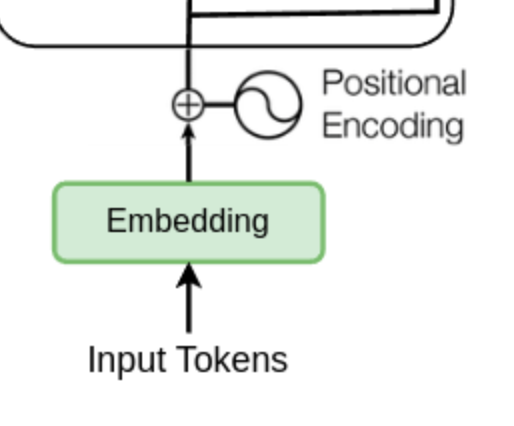

We'll first create an initiation for 2 of our input matrices: position and token embedding.  Both of these are a table of weigths that have `n_embd` number of columns to store information about the position or token. The more columns you add, the more complex information can be stored but the more compute is needed.  For now we'll let each position or column store up to 4 channels of information.  Before starting though we need to initialize the layer with a set of data.

In [16]:
# weighted token embedding
wte = nn.Embedding(vocab_size, n_embd)
# weighted position embedding
wpe = nn.Embedding(block_size, n_embd)


**Positional Embeddings**
now we need to pluck the weight of each position out of the position embedding.  Since we are creating a simple left to right, position 1 to n, we can just create an array from 0 to n based on the context, `T`, then pluck those rows out.  The resulting matrix from this operation is a `T, n_embd` based vector. 

In [17]:
pos = torch.arange(0, T, dtype=torch.long)
pos

tensor([0, 1, 2, 3, 4, 5, 6, 7])

for each element, look up the row in `wpe` and pluck it out. 

In [18]:
pos_emb = wpe(pos)
pos_emb.shape, pos_emb

(torch.Size([8, 4]),
 tensor([[ 1.9522, -0.3816, -1.1416, -1.6634],
         [-1.6932, -2.1286,  0.4067, -0.5871],
         [ 0.3960, -0.3368, -1.6697,  0.8484],
         [ 0.6730, -0.5939,  0.2283, -2.3631],
         [-0.5305, -0.7637, -0.3460, -0.6389],
         [-0.4112,  1.7696,  1.3983,  0.3472],
         [ 2.5798, -1.7871,  0.8409, -0.3673],
         [ 0.2490, -1.4966,  0.1369, -0.3270]], grad_fn=<EmbeddingBackward0>))

**Word Embeddings** 
Similarly we need to pluck out the rows from the token table, `wte` for the tokens in our example. Since our example is already represented as indices, we can simple use `x` directly. The resulting matrix from this operation is a `B,T, n_embd` based vector since `x` is `B,T` and `tok_emb` is `vocab_size,n_embd` and when we index `wte` by `x` each entry in x replaces `n_embd` based vector at that position in `wte`.

In [19]:
x

tensor([[35, 15, 32,  9,  5, 20, 30, 15],
        [11,  9,  6, 20,  5,  0, 13, 21]])

In [20]:
tok_emb = wte(x)
tok_emb.shape, tok_emb

(torch.Size([2, 8, 4]),
 tensor([[[ 0.1136, -1.4849,  1.4277,  0.1547],
          [ 0.2688,  0.2485,  1.2687,  0.4042],
          [ 2.0519,  0.0281,  0.5861,  0.0717],
          [ 0.9967, -0.5568,  1.2159,  0.0545],
          [-1.2428, -1.0149, -0.2173, -0.2780],
          [ 0.4639, -2.0828, -0.7092, -1.6054],
          [-1.0912,  0.9152, -0.1260,  0.2344],
          [ 0.2688,  0.2485,  1.2687,  0.4042]],
 
         [[ 0.0702,  1.0425, -0.4681,  0.6498],
          [ 0.9967, -0.5568,  1.2159,  0.0545],
          [-0.6706, -1.4959,  0.3985,  0.9564],
          [ 0.4639, -2.0828, -0.7092, -1.6054],
          [-1.2428, -1.0149, -0.2173, -0.2780],
          [-0.3522, -0.6030,  1.1390, -0.4862],
          [ 0.7701, -0.1502,  0.9686,  0.4959],
          [-2.4833,  0.4486,  0.1962,  0.0087]]], grad_fn=<EmbeddingBackward0>))

**Impact of the position and token together**
To ensure that the position and token together impact the next token prediction, we sum the two so that the weigth of each token is impacted by the weigth of it's relative position.   To do this we sum `tok_emb` and `pos_emb` together. Quickly we can see the dimensions don't match as 
* `tok_emb` > `B,T,n_embd`
* `pos_emb` >   `T,n_embd`

Since we have multiple examples with the same ordering, we simply add pos_emb at the same level to each entry on the `B` dimension, something that pytorch does for us automatically. 

In [21]:
x = tok_emb + pos_emb
x

tensor([[[ 2.0657, -1.8665,  0.2860, -1.5086],
         [-1.4244, -1.8801,  1.6755, -0.1829],
         [ 2.4479, -0.3087, -1.0836,  0.9201],
         [ 1.6697, -1.1507,  1.4442, -2.3086],
         [-1.7733, -1.7786, -0.5634, -0.9170],
         [ 0.0527, -0.3132,  0.6891, -1.2582],
         [ 1.4886, -0.8720,  0.7150, -0.1329],
         [ 0.5178, -1.2481,  1.4056,  0.0771]],

        [[ 2.0224,  0.6610, -1.6098, -1.0136],
         [-0.6965, -2.6854,  1.6226, -0.5326],
         [-0.2746, -1.8327, -1.2713,  1.8048],
         [ 1.1368, -2.6767, -0.4809, -3.9685],
         [-1.7733, -1.7786, -0.5634, -0.9170],
         [-0.7634,  1.1666,  2.5373, -0.1390],
         [ 3.3499, -1.9373,  1.8095,  0.1286],
         [-2.2342, -1.0480,  0.3331, -0.3184]]], grad_fn=<AddBackward0>)

### Transformer Layers
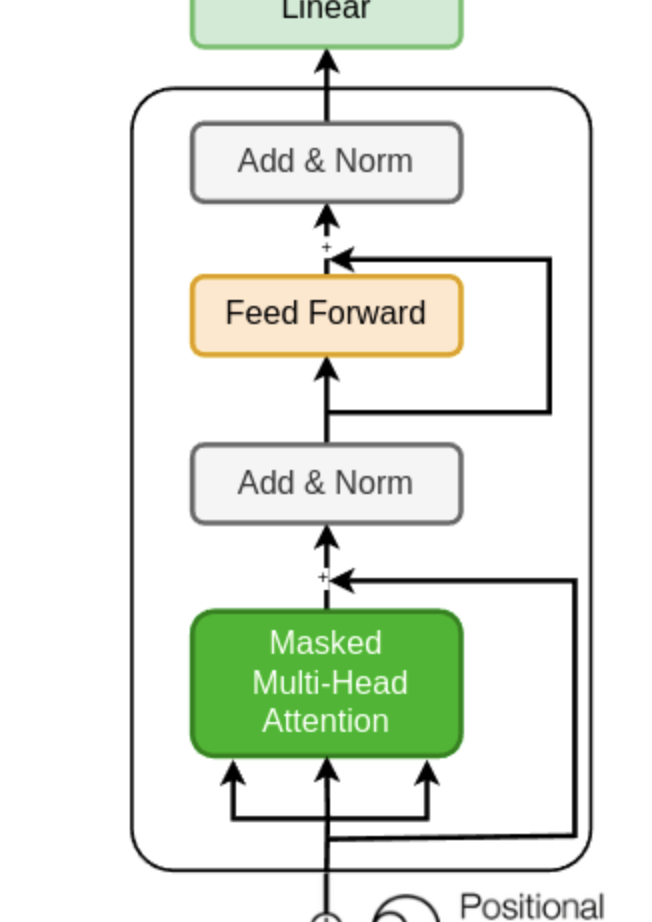

The transformer block is multiple parallel repetitions of the same matrix operations done independently.  This adds both depth and breadth to the computation.  Each block is the same steps of
1. Layer normalization
2. Causal self attention
3. Layer normalization (again)
4. Multi-layer peceptron (MLP)

Both steps 2 and 4 are also multi-layered so we'll go through each layer independently.  You'll notice the arrows in the diagram bypassing the causal self attention and the MLP.  This is to ensure that the weights of any one layer do not get overweighted. We achieve this by simply adding the input with the layer's calculations together, as you'll see. 

#### Layer Normalization
With Layer normalization, we review the row and adjust based on how far away it is from the mean. This means an array of `[1,2,3,4]` and `[2,4,6,8]` will actually have the same normalized entries after layer normaliztion.  This layer adds regularization which helps with overall learning speed. The formula applied is:

$y = \frac{x - \mathbb{E}[x]}{\sqrt{\operatorname{Var}[x] + \epsilon}}\,\gamma + \beta$

Note that even though we weill do layer normalization again, we keep this as a separate layer so that it's impact can be adjusted independent of other normalization layers.

In [22]:
n_layer = 1 # how many transformer layers to include

In [23]:
ln_1 = nn.LayerNorm(n_embd)

## Example 
ln_1(torch.tensor(
    [
        [1.0,2.0,3.0,4.0],
        [2.0,4.0,6.0,8.0]
    ]))

tensor([[-1.3416, -0.4472,  0.4472,  1.3416],
        [-1.3416, -0.4472,  0.4472,  1.3416]],
       grad_fn=<NativeLayerNormBackward0>)

In [24]:
x_norm = ln_1(x)
x_norm.shape, x_norm

(torch.Size([2, 8, 4]),
 tensor([[[ 1.4797, -1.0265,  0.3454, -0.7985],
          [-0.7055, -1.0364,  1.5458,  0.1962],
          [ 1.4633, -0.6010, -1.1814,  0.3192],
          [ 1.0358, -0.6278,  0.9028, -1.3108],
          [-0.9671, -0.9770,  1.3039,  0.6402],
          [ 0.3690, -0.1501,  1.2721, -1.4910],
          [ 1.3407, -1.3211,  0.4683, -0.4878],
          [ 0.3444, -1.5002,  1.2717, -0.1159]],
 
         [[ 1.4068,  0.4527, -1.1386, -0.7208],
          [-0.0810, -1.3854,  1.4399,  0.0265],
          [ 0.0857, -1.0381, -0.6332,  1.5856],
          [ 1.3395, -0.5997,  0.5168, -1.2566],
          [-0.9671, -0.9770,  1.3039,  0.6402],
          [-1.1537,  0.3675,  1.4478, -0.6616],
          [ 1.2779, -1.4115,  0.4944, -0.3607],
          [-1.4872, -0.2425,  1.2066,  0.5231]]],
        grad_fn=<NativeLayerNormBackward0>))

#### Causal Self Attention / Flash Attention

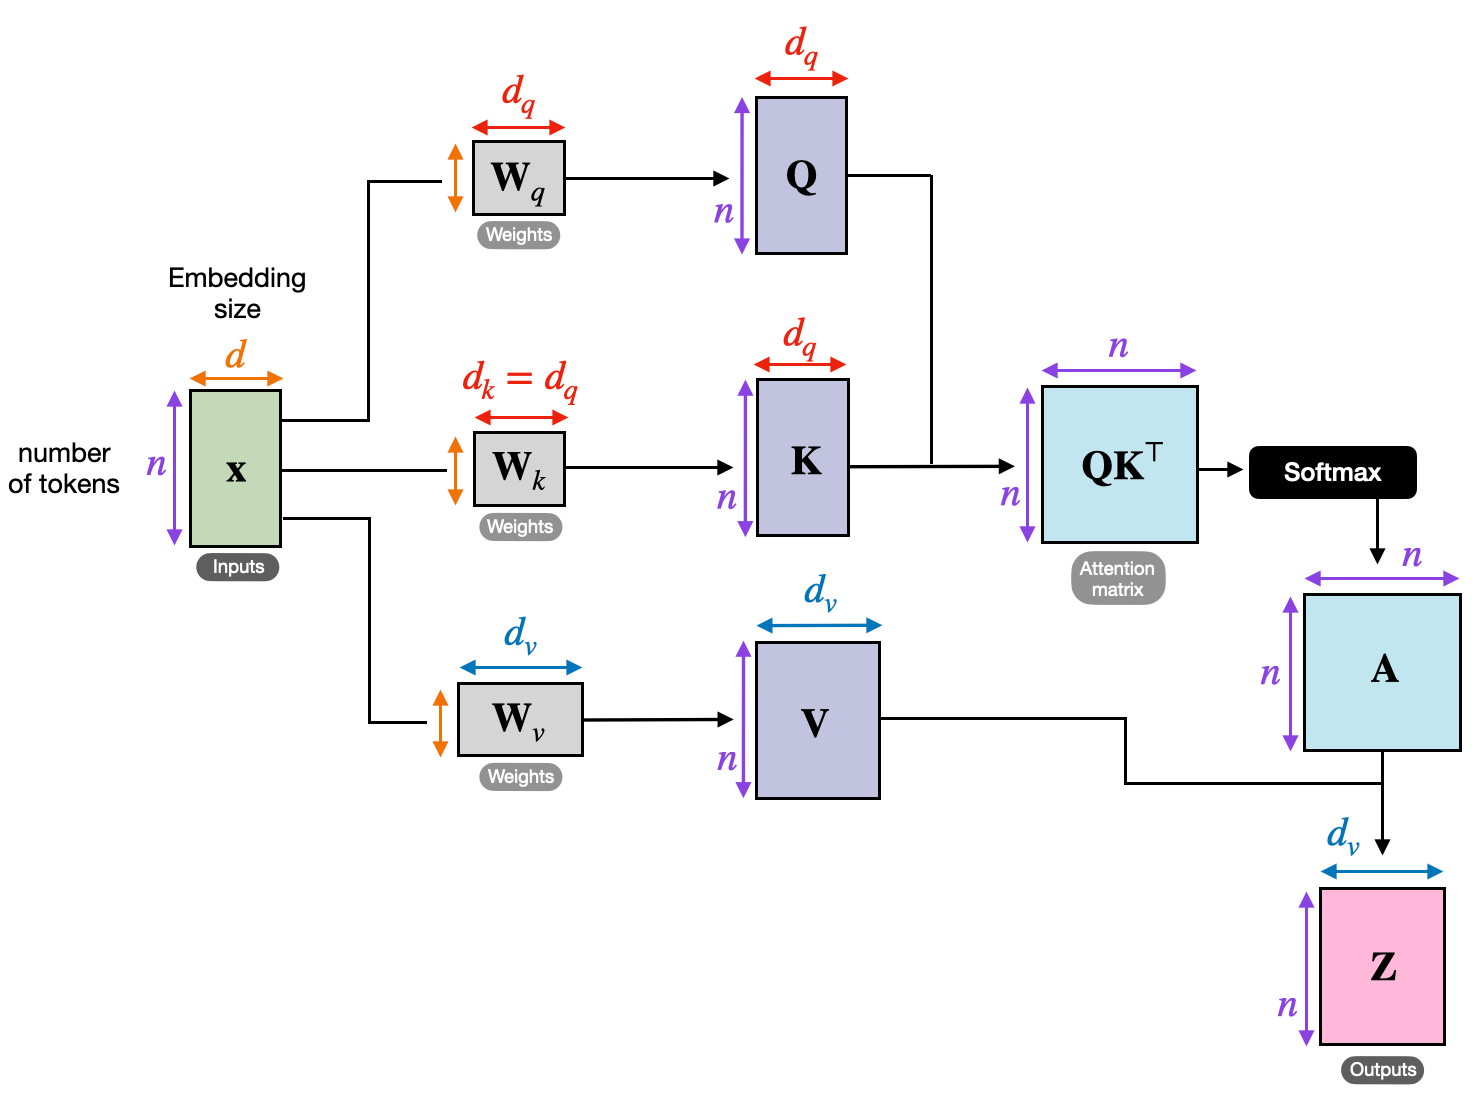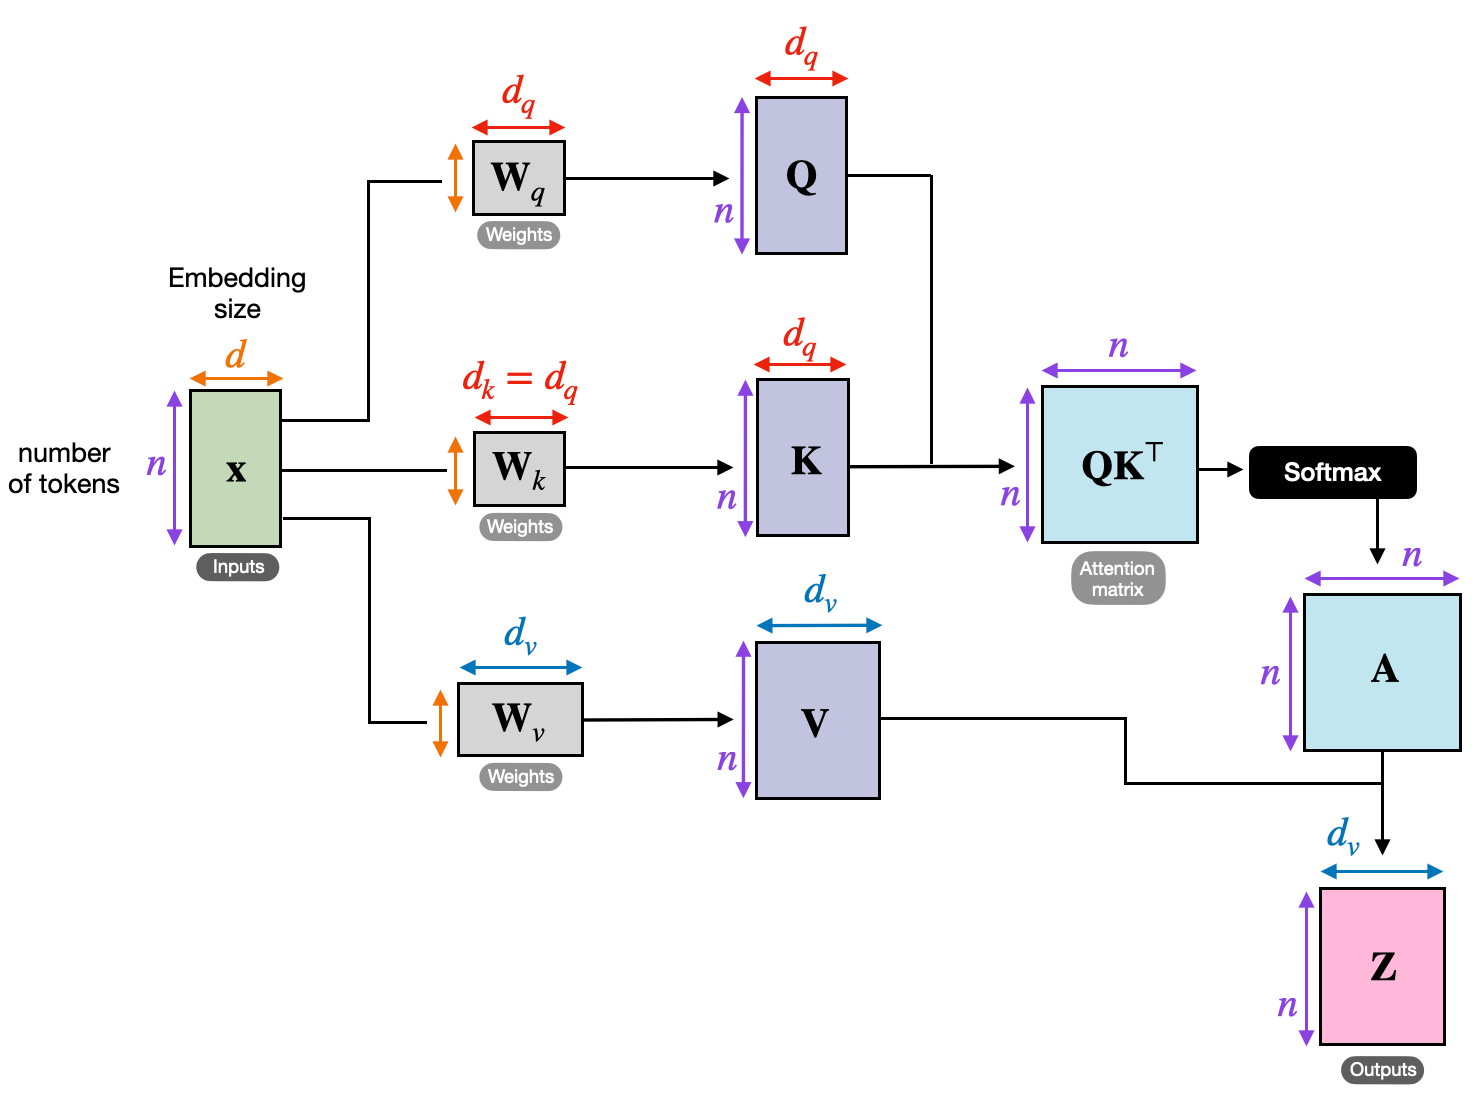

Causal self-attention is self-attention with a strictly lower-triangular mask, so each position $i$ can attend only to positions $j≤i$ (no look-ahead). For each position in a sequence, the model decides which earlier tokens matter and blends their information to generate the upcoming token, but the model is not allowed to peek at tokens to the right. Recall that we created an input `x` that has all of the tokens in the sequence. With causal self attention we ensure that the prediction of `y` is not learning in an example from tokens to the right of it. 

Causal self attention uses 3 linear projections to create representations of 3 concepts to help derive the next token: query, key, and value. FlashAttention takes the input `x` of shape $(B,T,C)$, linearly projects the last dimension to `Q, K, V` by multiplying each token vector $x_{b,t,:}$ with learned weight matrices `Q, K,V` (often via one combined QKV linear) and adding biases (which we do not have. Then we compute the causal dot-product attention with softmax per head, concatenate the heads, and apply a final linear layer to produce the output.

The Q,K,V matrix do the following: 
* **Query** - the current position’s “search request.” Every layer and head issues queries that can look for many things (antecedent, rhythm, agreement, etc.).
* **Key** - a matching tag/address for each allowed position. It is compared with the query to produce relevance scores
* **Value** - the payload you actually mix in once something matches. It’s a learned projection of the token’s representation so the model can copy the right kind of information.

This layer starts by taking a linear layer that has `n_embd` rows and then  `n_embd` columns for each: the query, key and value.  This allows the projection of the `x_norm` to be split into the 3 components, select from them. We then use `scaled_dot_product_attention` to provide the attention masking and normalization, including a lower triangle mask to prevent look-ahead, and final project that onto a `n_embd x n_embd` matrix to return the output. 

We start by creation the 2 default layers. Also we'll set heads to 2.  The heads allow the layer to specialize in different concepts since each head creates it's own Q,K,V

In [25]:
from torch.nn import functional as F
n_head = 2

In [28]:
c_attn = nn.Linear(n_embd, 3 * n_embd)
c_attn

Linear(in_features=4, out_features=12, bias=True)

In [29]:
c_proj = nn.Linear(n_embd, n_embd)
c_proj

Linear(in_features=4, out_features=4, bias=True)

#### Creating Query, Key, Value
We'll now create the query, key, and value.  We'll dynamically derive the size to add scalability. 

In [30]:
B, T, C = x_norm.size()
B, T, C

(2, 8, 4)

In [31]:
x_norm

tensor([[[ 1.4797, -1.0265,  0.3454, -0.7985],
         [-0.7055, -1.0364,  1.5458,  0.1962],
         [ 1.4633, -0.6010, -1.1814,  0.3192],
         [ 1.0358, -0.6278,  0.9028, -1.3108],
         [-0.9671, -0.9770,  1.3039,  0.6402],
         [ 0.3690, -0.1501,  1.2721, -1.4910],
         [ 1.3407, -1.3211,  0.4683, -0.4878],
         [ 0.3444, -1.5002,  1.2717, -0.1159]],

        [[ 1.4068,  0.4527, -1.1386, -0.7208],
         [-0.0810, -1.3854,  1.4399,  0.0265],
         [ 0.0857, -1.0381, -0.6332,  1.5856],
         [ 1.3395, -0.5997,  0.5168, -1.2566],
         [-0.9671, -0.9770,  1.3039,  0.6402],
         [-1.1537,  0.3675,  1.4478, -0.6616],
         [ 1.2779, -1.4115,  0.4944, -0.3607],
         [-1.4872, -0.2425,  1.2066,  0.5231]]],
       grad_fn=<NativeLayerNormBackward0>)

Now we'll take x_norm and every projection `C` is added with the corresponding layer in `c_attn` to creation the `qkv` combined matrix leading to a 3x size increase. the `C` in `x_norm` is projected 3 times to align with the 3x `C` dimension in `c_attn`

In [32]:
qkv = c_attn(x_norm)
qkv.shape, qkv

(torch.Size([2, 8, 12]),
 tensor([[[ 0.8634, -1.3358,  0.9027,  1.4253, -0.9695, -0.9618, -0.6907,
            0.2204,  0.4763,  0.2178,  0.0164,  0.5105],
          [ 0.2891, -0.6689,  0.7035,  0.8450, -1.3645, -0.3014,  0.5669,
            0.4331, -0.6920,  0.4902, -0.0021, -0.0072],
          [ 0.6548, -0.1564,  0.5406,  0.3057,  0.0413, -0.8184, -0.7286,
           -0.4333,  1.2031,  0.2761, -0.8961,  0.3219],
          [ 0.8888, -1.6484,  0.6183,  1.5523, -1.0700, -0.9057, -0.6604,
            0.7281,  0.0340,  0.2824,  0.5837,  0.2685],
          [ 0.1595, -0.2745,  0.6192,  0.4939, -1.1749, -0.1828,  0.7278,
            0.2627, -0.6420,  0.5350, -0.2698, -0.0990],
          [ 0.8131, -1.6530,  0.2447,  1.3944, -1.0081, -0.7535, -0.5085,
            1.1208, -0.3782,  0.3860,  0.9598, -0.0616],
          [ 0.7752, -1.2089,  1.0840,  1.4123, -1.1330, -0.8953, -0.4739,
            0.0632,  0.4113,  0.2215, -0.1788,  0.5839],
          [ 0.5261, -1.0565,  1.1208,  1.3300, -1.5218, -0

now, we will split up qkv to create the 3 separate matricies that can ename the query, key, and value to work together to create complex concept embeddings. We also then have to split up each matrix into its own heads (shown as columns `dim=3`) so that concepts can get separately embeded and adjusted during back_prop. 

In [33]:
q,k,v = qkv.split(n_embd, dim=2)
q = q.view(B, T, n_head, C // n_head).transpose(1, 2)
k = k.view(B, T, n_head, C // n_head).transpose(1, 2)
v = v.view(B, T, n_head, C // n_head).transpose(1, 2)
q.shape, q, k.shape, k, v.shape, v

(torch.Size([2, 2, 8, 2]),
 tensor([[[[ 0.8634, -1.3358],
           [ 0.2891, -0.6689],
           [ 0.6548, -0.1564],
           [ 0.8888, -1.6484],
           [ 0.1595, -0.2745],
           [ 0.8131, -1.6530],
           [ 0.7752, -1.2089],
           [ 0.5261, -1.0565]],
 
          [[ 0.9027,  1.4253],
           [ 0.7035,  0.8450],
           [ 0.5406,  0.3057],
           [ 0.6183,  1.5523],
           [ 0.6192,  0.4939],
           [ 0.2447,  1.3944],
           [ 1.0840,  1.4123],
           [ 1.1208,  1.3300]]],
 
 
         [[[ 0.8591, -0.5998],
           [ 0.4259, -0.9187],
           [ 0.1644,  0.6321],
           [ 0.9325, -1.5590],
           [ 0.1595, -0.2745],
           [ 0.3953, -0.8288],
           [ 0.7385, -1.1438],
           [ 0.1017, -0.0924]],
 
          [[-0.1503,  0.3365],
           [ 1.0024,  1.1730],
           [ 0.6842, -0.2288],
           [ 0.6167,  1.4727],
           [ 0.6192,  0.4939],
           [-0.2715,  0.5223],
           [ 1.1365,  1.3862],


#### Cross Attention / Dot-product attention. 
With the separated query, key, value, we now need to run the dot product, but restrict each position to only be able to look at embeddings for tokens that have come before it.  To do this, flash attention tiles Q,K,V and applies masking and softmax on the fly. If done without flash attention, you'd need to materializes the large `(T,T)` matrix for all the queries and keys. It then applies a mask fill to zero out the upper triangle, then does a dot product and softmax with the value matrix.  Finally we collapse the heads together back into the same dimension. 

*Note we use `contiguous` here to force `transpose()` to create a new matrix in memory. This allows the heads to learn independently

In [34]:
fa = F.scaled_dot_product_attention(q, k, v, is_causal=True)
fa = fa.transpose(1, 2).contiguous().view(B, T, C)
fa.shape, fa

(torch.Size([2, 8, 4]),
 tensor([[[ 0.4763,  0.2178,  0.0164,  0.5105],
          [ 0.0055,  0.3276,  0.0039,  0.1586],
          [ 0.5474,  0.3082, -0.2124,  0.2180],
          [ 0.5674,  0.2825,  0.1130,  0.2067],
          [ 0.1473,  0.3488, -0.0729,  0.1314],
          [ 0.3173,  0.3176,  0.2994,  0.0966],
          [ 0.2968,  0.3104,  0.1679,  0.0908],
          [ 0.1941,  0.3172,  0.1186,  0.1313]],
 
         [[ 1.0483,  0.3277, -0.0555, -0.0687],
          [ 0.6072,  0.3466, -0.0750,  0.1862],
          [ 0.4323,  0.3876, -0.6609,  0.1552],
          [ 0.6726,  0.3341, -0.0919,  0.2067],
          [ 0.2495,  0.3803, -0.2767,  0.1084],
          [ 0.1936,  0.4001,  0.0596, -0.0389],
          [ 0.3365,  0.3662,  0.1566, -0.1266],
          [-0.0251,  0.4243, -0.0870, -0.0065]]], grad_fn=<ViewBackward0>))

#### Final projection and output
Finally, we will now project the cross attention matrix on another final linear layer `n_embd x n_embd`

In [35]:
x_norm = c_proj(fa)
x_norm.shape, x_norm

(torch.Size([2, 8, 4]),
 tensor([[[-0.0024,  0.6375, -0.2494,  0.0960],
          [-0.1264,  0.4752, -0.4213,  0.2466],
          [ 0.0366,  0.5954, -0.1444,  0.1942],
          [ 0.0688,  0.7202, -0.2409,  0.1735],
          [-0.0813,  0.5051, -0.3390,  0.2418],
          [ 0.0083,  0.7031, -0.3928,  0.2119],
          [-0.0069,  0.6429, -0.3625,  0.2327],
          [-0.0505,  0.5876, -0.3851,  0.2297]],
 
         [[ 0.2517,  0.8456, -0.0015,  0.2324],
          [ 0.0685,  0.6804, -0.1562,  0.1714],
          [-0.0302,  0.4002, -0.0399,  0.2464],
          [ 0.0877,  0.6960, -0.1271,  0.1628],
          [-0.0596,  0.4743, -0.2316,  0.2485],
          [-0.0383,  0.5837, -0.3570,  0.2718],
          [ 0.0293,  0.6642, -0.3401,  0.2953],
          [-0.1281,  0.4515, -0.3924,  0.2876]]], grad_fn=<ViewBackward0>))

### Residual (skip) connection
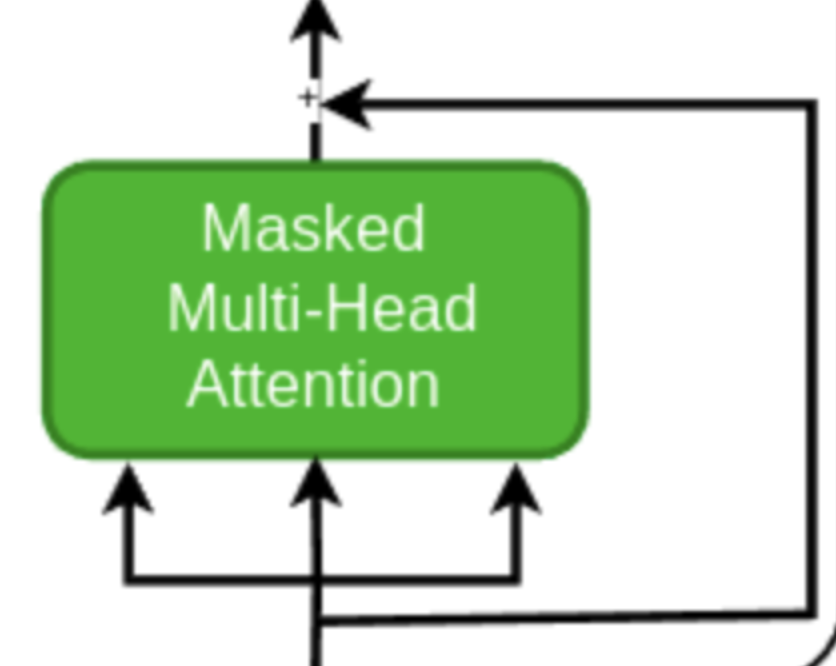

Modern networks also use skip connections, meaning they allows for pathway to bypass around "boxes", passing through through gradients during the backward pass.  This attribute ensures that the impact of each layer and head is normalized against the input embeddings themselves. Recall in the diagram we had the arrow that bypassed "masked multiheaded attention".  Functionally this is represented as

$y = f(x) + x$

To achieve this we simply sum the project matrix `x` with the normalized output `x_norm`.

In [36]:
x = x + x_norm
x.shape, x

(torch.Size([2, 8, 4]),
 tensor([[[ 2.0633, -1.2289,  0.0366, -1.4126],
          [-1.5509, -1.4049,  1.2541,  0.0637],
          [ 2.4845,  0.2867, -1.2280,  1.1143],
          [ 1.7385, -0.4305,  1.2033, -2.1351],
          [-1.8546, -1.2734, -0.9024, -0.6752],
          [ 0.0609,  0.3899,  0.2964, -1.0463],
          [ 1.4818, -0.2291,  0.3525,  0.0997],
          [ 0.4674, -0.6605,  1.0205,  0.3069]],
 
         [[ 2.2740,  1.5065, -1.6113, -0.7812],
          [-0.6280, -2.0050,  1.4664, -0.3611],
          [-0.3048, -1.4325, -1.3111,  2.0511],
          [ 1.2246, -1.9807, -0.6080, -3.8057],
          [-1.8329, -1.3043, -0.7949, -0.6685],
          [-0.8017,  1.7503,  2.1803,  0.1328],
          [ 3.3793, -1.2731,  1.4694,  0.4238],
          [-2.3623, -0.5966, -0.0593, -0.0308]]], grad_fn=<AddBackward0>))

### Layer Normalization 2
We'll run another round of norma now on the outputs of the Masked Multi-head attention and feed forward to ensure our values are not too spread apart.  This layer will run the same  the same normalization formula as before, but is it's own independent layer as it has different inputs. Recall the formula is: 

$y = \frac{x - \mathbb{E}[x]}{\sqrt{\operatorname{Var}[x] + \epsilon}}\,\gamma + \beta$

Because we will do feed forward again for the next layer, MLP, we'll once again branch `x` for the normalization and MLP and then sum it back togehter with `x`

In [37]:
ln_2 = nn.LayerNorm(n_embd)

In [38]:
x_norm_2 = ln_2(x)
x_norm_2.shape, x_norm_2

(torch.Size([2, 8, 4]),
 tensor([[[ 1.5856, -0.7886,  0.1241, -0.9211],
          [-0.9930, -0.8660,  1.4473,  0.4116],
          [ 1.3530, -0.2807, -1.4067,  0.3345],
          [ 1.0855, -0.3463,  0.7323, -1.4715],
          [-1.5206, -0.2175,  0.6143,  1.1238],
          [ 0.2366,  0.8102,  0.6470, -1.6938],
          [ 1.6407, -1.0186, -0.1147, -0.5075],
          [ 0.3033, -1.5580,  1.2162,  0.0385]],
 
         [[ 1.2088,  0.7273, -1.2284, -0.7077],
          [-0.1991, -1.3130,  1.4953,  0.0168],
          [-0.0397, -0.8461, -0.7593,  1.6450],
          [ 1.3653, -0.3733,  0.3713, -1.3633],
          [-1.4827, -0.3347,  0.7714,  1.0460],
          [-1.3409,  0.7752,  1.1317, -0.5660],
          [ 1.4107, -1.3476,  0.2784, -0.3415],
          [-1.6827,  0.1742,  0.7392,  0.7692]]],
        grad_fn=<NativeLayerNormBackward0>))

### Feed Forward (aka Multi-layer Perceptron)

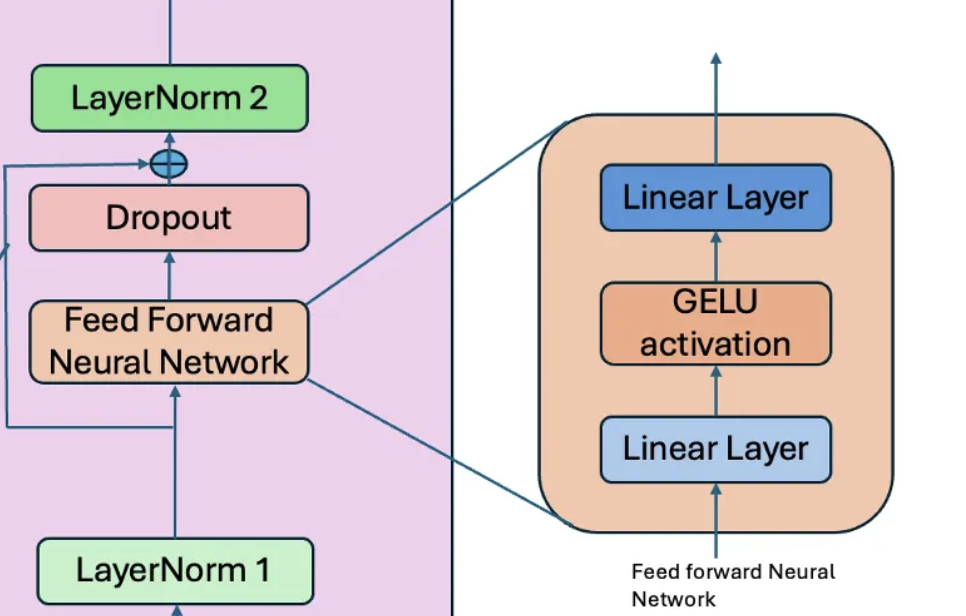

The feed-forward sublayer consists of two-layer mirroring a multi-layer perceptron, MLP.  These layers mix the features within each token vector but never across time. The output `x` from multi-headed attention starts as `B x T x C`.  Feed forward 
1. Calculates `4C` using a $XW^T + B$ linear layer 
2. Normalizes the data using a `tanh` based GELU layer. This layer pushes extreme values to +/- 1
3. Projects back down to `C` with a final $XW^T + B$ linear layer.

The MLP nonlinearly re-expresses each token's channel features before being aggregated across the hidden layers and passed to the output layer. 

We'll first start by creating the 3 different layers:
1. `mlp_fc` - Linear layer to project up to `4C`
2. `mlp_gelu` - tanh layer
3. `mlp_proj` - Linear layer to project down to `C`

In [52]:
mlp_fc = nn.Linear(n_embd, 4 * n_embd)
mlp_gelu = nn.GELU(approximate='tanh')
mlp_proj = nn.Linear(4 * n_embd, n_embd)


mlp_fc, mlp_fc.weight.shape, mlp_gelu, mlp_proj, mlp_proj.weight.shape

(Linear(in_features=4, out_features=16, bias=True),
 torch.Size([16, 4]),
 GELU(approximate='tanh'),
 Linear(in_features=16, out_features=4, bias=True),
 torch.Size([4, 16]))

Now we'll take `x_norm_2` and every projection `C` is added with the corresponding weights in `mlp_fc` to creation our linear project up to `4c`

In [43]:
x_mlp = mlp_fc(x_norm_2)
x_mlp.shape, x_mlp

(torch.Size([2, 8, 16]),
 tensor([[[ 1.0942e+00, -5.9510e-01, -2.0283e-01, -1.3351e-02,  1.6307e+00,
           -1.2061e-01,  2.2914e-01, -2.6528e-01, -6.7612e-01,  1.0242e+00,
            6.3583e-01, -8.7001e-01, -4.0111e-01,  5.6005e-01,  7.4088e-02,
            6.9449e-01],
          [-4.7891e-01, -5.2155e-01, -5.1092e-01, -8.1366e-02, -3.6182e-01,
            1.1473e-03, -9.7258e-01, -1.2869e-02,  1.1552e+00, -6.4736e-02,
           -2.5657e-01,  1.1643e+00, -5.4489e-01,  1.3573e-01, -1.3520e-01,
            4.6407e-01],
          [ 1.1519e+00,  6.8539e-01, -3.6487e-01, -6.6888e-01,  1.1869e+00,
            4.9513e-01,  6.3729e-01,  5.8346e-01, -5.1462e-01,  1.0454e+00,
            2.7784e-01, -5.9473e-01,  4.4586e-01,  5.9018e-02, -5.5789e-01,
            4.1935e-01],
          [ 9.1409e-01, -9.6617e-01, -2.1870e-01,  2.8561e-01,  1.5254e+00,
           -1.4902e-01, -3.0598e-01, -6.8916e-01, -6.4069e-01,  8.4777e-01,
            4.4161e-01, -5.4658e-01, -7.9756e-01,  4.0176e-01,  

Now we'll apply the tanh approximation (GELU - tanh) which smoothly gates each input `x_mlp`.  This shrinks negative/small values and passing large positives nearly linearly for stable, well-behaved activations.  `tanh` is applied element wise across the full `x_mlp`

In [44]:
x_mlp = mlp_gelu(x_mlp)
x_mlp.shape, x_mlp

(torch.Size([2, 8, 16]),
 tensor([[[ 9.4420e-01, -1.6421e-01, -8.5115e-02, -6.6045e-03,  1.5466e+00,
           -5.4517e-02,  1.3533e-01, -1.0489e-01, -1.6873e-01,  8.6744e-01,
            4.6892e-01, -1.6728e-01, -1.3806e-01,  3.9888e-01,  3.9232e-02,
            5.2520e-01],
          [-1.5135e-01, -1.5700e-01, -1.5570e-01, -3.8045e-02, -1.2981e-01,
            5.7419e-04, -1.6099e-01, -6.3685e-03,  1.0118e+00, -3.0697e-02,
           -1.0231e-01,  1.0219e+00, -1.5963e-01,  7.5194e-02, -6.0328e-02,
            3.1496e-01],
          [ 1.0081e+00,  5.1636e-01, -1.3049e-01, -1.6846e-01,  1.0471e+00,
            3.4150e-01,  4.7030e-01,  4.2019e-01, -1.5616e-01,  8.9055e-01,
            1.6932e-01, -1.6418e-01,  2.9967e-01,  3.0898e-02, -1.6095e-01,
            2.7782e-01],
          [ 7.4912e-01, -1.6147e-01, -9.0419e-02,  1.7491e-01,  1.4282e+00,
           -6.5682e-02, -1.1622e-01, -1.6915e-01, -1.6717e-01,  6.7957e-01,
            2.9614e-01, -1.5981e-01, -1.6961e-01,  2.6357e-01,  

Finally we'll take `x_mlp` and project `4C` back down to `C` using the weights in `mlp_proj`.  Even though the layer weights are `4x16` the transpose in $XW^T + B$ allows to project back down.

In [45]:
x_mlp = mlp_proj(x_mlp)
x_mlp.shape, x_mlp

(torch.Size([2, 8, 4]),
 tensor([[[ 0.4929,  0.4719,  0.0597,  0.0932],
          [-0.0872,  0.2817, -0.1880, -0.1153],
          [ 0.2469,  0.4655,  0.1812,  0.1970],
          [ 0.4714,  0.3933,  0.0430, -0.0061],
          [-0.2883,  0.3253, -0.1234, -0.0247],
          [ 0.3217,  0.2644,  0.1123, -0.0495],
          [ 0.4538,  0.4867,  0.0794,  0.1119],
          [ 0.2251,  0.3613, -0.1547, -0.1417]],
 
         [[ 0.3693,  0.4211,  0.1370,  0.1822],
          [ 0.1215,  0.3084, -0.1849, -0.1511],
          [-0.0980,  0.4470,  0.0106, -0.0533],
          [ 0.5064,  0.4370,  0.0559,  0.0471],
          [-0.2636,  0.3215, -0.1359, -0.0426],
          [-0.1623,  0.1127,  0.0042,  0.0073],
          [ 0.4170,  0.4621,  0.0256,  0.0426],
          [-0.3076,  0.2615, -0.0989,  0.0201]]], grad_fn=<ViewBackward0>))

### Residual (skip) connection 2

Our transformer also utilizes use skip connections for the feed forward block for passing through gradients during the backward pass.  Recall that  this is represented as

$y = f(x) + x$

We will again simply sum the project matrix `x` with the normalized output `x_mlp`.

In [53]:
x = x_mlp + x

x.shape, x

(torch.Size([2, 8, 4]),
 tensor([[[ 2.5563, -0.7570,  0.0964, -1.3194],
          [-1.6381, -1.1232,  1.0662, -0.0516],
          [ 2.7314,  0.7522, -1.0468,  1.3113],
          [ 2.2099, -0.0372,  1.2463, -2.1412],
          [-2.1429, -0.9482, -1.0258, -0.6999],
          [ 0.3827,  0.6543,  0.4087, -1.0959],
          [ 1.9356,  0.2577,  0.4319,  0.2117],
          [ 0.6925, -0.2992,  0.8658,  0.1652]],
 
         [[ 2.6434,  1.9277, -1.4743, -0.5990],
          [-0.5066, -1.6966,  1.2816, -0.5123],
          [-0.4028, -0.9855, -1.3005,  1.9978],
          [ 1.7310, -1.5437, -0.5521, -3.7587],
          [-2.0964, -0.9827, -0.9308, -0.7111],
          [-0.9641,  1.8630,  2.1845,  0.1401],
          [ 3.7963, -0.8111,  1.4950,  0.4664],
          [-2.6699, -0.3351, -0.1582, -0.0106]]], grad_fn=<AddBackward0>))

#### Transofrmer: Final Layer Normalization 

The final step in the transformer is to aggregate and normalize before calculating the final projections. This layer is similar to the previous normalization layers. This layer will run the same normalization formula as before, but is it's own independent layer as it has different inputs. Recall the formula is: 

$y = \frac{x - \mathbb{E}[x]}{\sqrt{\operatorname{Var}[x] + \epsilon}}\,\gamma + \beta$

Since this is the final layer, we will not have a residual connection so we do not need to branch `x`. 

In [55]:
ln_f = nn.LayerNorm(n_embd)
ln_f

LayerNorm((4,), eps=1e-05, elementwise_affine=True)

In [56]:
x = ln_f(x)
x.shape, x

(torch.Size([2, 8, 4]),
 tensor([[[ 1.6287, -0.6084, -0.0322, -0.9881],
          [-1.1559, -0.6605,  1.4458,  0.3705],
          [ 1.3255, -0.1365, -1.4655,  0.2765],
          [ 1.1605, -0.2189,  0.5690, -1.5105],
          [-1.6908,  0.4611,  0.3214,  0.9084],
          [ 0.4270,  0.8199,  0.4646, -1.7116],
          [ 1.7205, -0.6335, -0.3890, -0.6980],
          [ 0.7346, -1.4309,  1.1131, -0.4169]],
 
         [[ 1.1817,  0.7628, -1.2284, -0.7161],
          [-0.1392, -1.2580,  1.5418, -0.1446],
          [-0.1778, -0.6281, -0.8716,  1.6775],
          [ 1.4003, -0.2600,  0.2428, -1.3830],
          [-1.7007,  0.3667,  0.4631,  0.8709],
          [-1.3785,  0.8233,  1.0737, -0.5186],
          [ 1.5159, -1.2127,  0.1530, -0.4562],
          [-1.7224,  0.4208,  0.5831,  0.7186]]],
        grad_fn=<NativeLayerNormBackward0>))

### Output Layers AKA Model Head.
The combination of masked multi-head attention and feed forward, along with the normalization and residual connections is considered the "transformer".  In practice this layer is horizontally scaled to run many layers in parallel.  Once those layers are complete during the forward pass we then start the output process that results in `logits` which is a representation of the probability of each token being the next token given the input.  

This layer is also known as the model **head**, not to be confused with attention heads. This layer is called this because it is a small, task-specific module attached to a model’s shared backbone that maps hidden features to the final outputs.  In our examples case, this is a linear layer mapping the backbone to vocab logits. The benefit of this structure is that you can use the shared hidden features and train different heads for different tasks without starting from scratch. An example would be a classifier head, or policy head in RL.

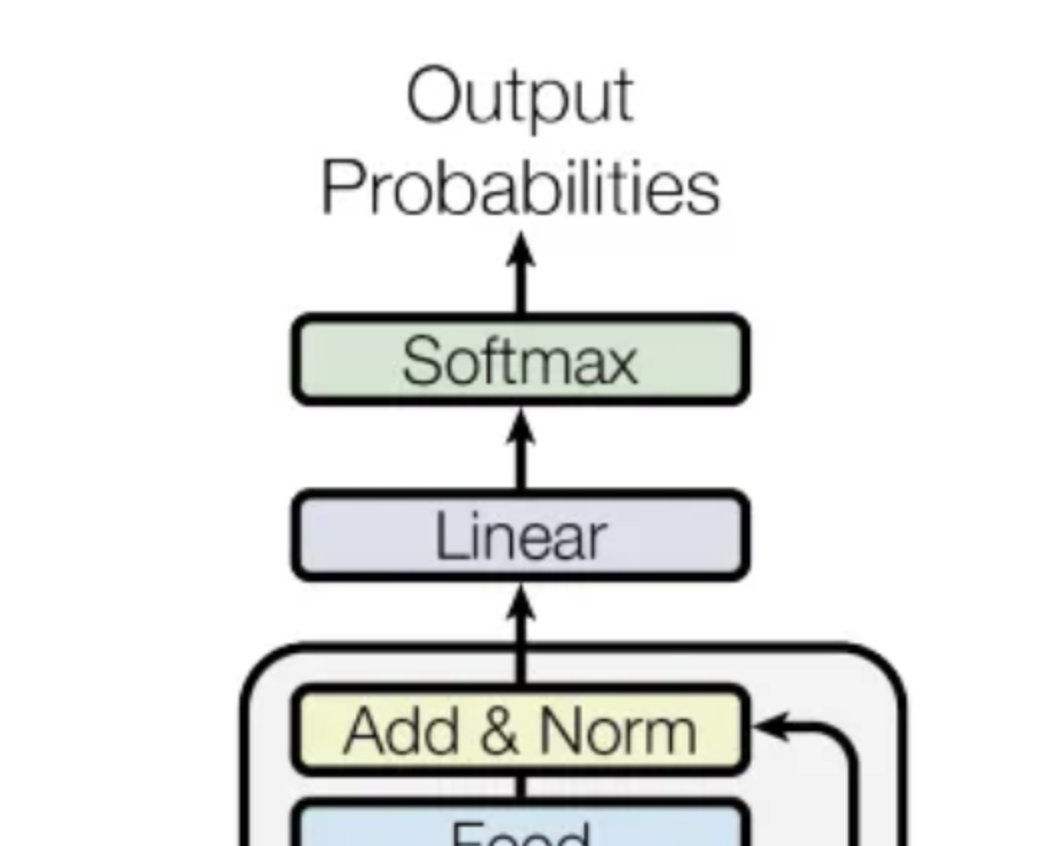

For our head we want to map to to a predicted token which we'll look at as `logits`. In the process to generate `logits` we take the normalize output `x` of the transformers, then project, using a linear layer, to the vocabulary resulting in a `B, T, vocab_size` matrix known as `logits`.  

In training, the `logits` are then compared with `y` to see how close the  model is to predicting the correct next token. For inference, the `logits` are then used to drive sampling which is how the next token is then derived. 


We'll start with initializing a linear projection layer.

In [57]:
lm_head = nn.Linear(n_embd, vocab_size, bias=False)
lm_head, lm_head.weight

(Linear(in_features=4, out_features=36, bias=False),
 Parameter containing:
 tensor([[ 0.3901,  0.0143, -0.3274,  0.0941],
         [-0.4869, -0.4060,  0.1201, -0.0232],
         [-0.3899, -0.3465, -0.0231, -0.4823],
         [ 0.0063, -0.1668,  0.0828, -0.0809],
         [ 0.1132, -0.4494,  0.3593, -0.1491],
         [-0.1724, -0.0498,  0.2679, -0.3366],
         [-0.0588,  0.1017,  0.0116, -0.0825],
         [ 0.1259,  0.2915,  0.0443,  0.0641],
         [ 0.1574, -0.1637, -0.0020, -0.4227],
         [-0.3300,  0.1684,  0.2807, -0.4972],
         [ 0.1741, -0.0940,  0.2979,  0.3733],
         [-0.2267, -0.1228, -0.2282,  0.2394],
         [ 0.4127,  0.2156, -0.0802, -0.4587],
         [-0.1538, -0.2680,  0.3842,  0.4579],
         [ 0.4534, -0.2110,  0.3599, -0.1897],
         [ 0.3867,  0.2561,  0.2366, -0.1069],
         [ 0.2646,  0.3021,  0.2857, -0.4223],
         [ 0.4695,  0.2691, -0.2996, -0.2371],
         [-0.1365, -0.0748,  0.2959,  0.0426],
         [ 0.4495, -0.0441, -0.

#### LM Head - logits
finally we now project `x` onto the vocabulary resulting in a `B X T X vocab_size` final array `logits`.  This output correlates with the 
probabilty of each output token given the input context.  The best way to read  this is:

(dimension 0) we have 2 batches B, 
(dimension 1) each batch has an example for each value between 1 and context length T 
(dimension 2) for each example we see the probability of each token in our vocabulary

In [58]:
logits = lm_head(x)

logits.shape, logits

(torch.Size([2, 8, 36]),
 tensor([[[ 0.5442, -0.5269,  0.0531,  0.1890,  0.5935,  0.0734, -0.0764,
           -0.0370,  0.7736, -0.1577, -0.0378, -0.5237,  0.9968, -0.5522,
            1.0427,  0.5721,  0.6553,  0.8449, -0.2284,  1.2076, -0.2424,
           -0.2397,  1.2932, -0.8804,  1.1198, -0.3212,  0.0988,  0.5478,
           -0.4375, -0.3473, -0.4735,  0.3516,  0.6535, -0.3036, -0.0904,
           -0.6144],
          [-0.8988,  0.9959,  0.4675,  0.1926,  0.6302,  0.4948, -0.0130,
           -0.2502, -0.2333,  0.4918,  0.4300,  0.1019, -0.9053,  1.0800,
            0.0653, -0.3136, -0.2488, -1.2415,  0.6507, -1.0290,  0.3698,
           -0.1695, -1.0838,  0.8135, -0.2726, -0.6777,  0.6884, -0.8966,
            0.2767,  0.7191,  0.2345,  0.2330, -0.4791,  0.1590, -0.5204,
           -0.1378],
          [ 1.0210, -0.7723, -0.5690, -0.1126, -0.3564, -0.7074, -0.1316,
            0.0799,  0.1170, -1.0092, -0.0898,  0.1169,  0.5083, -0.6038,
            0.0499,  0.1013, -0.2260,  0.9591

### Loss calculation
Now we have to see how good our prediction is.  Since we haven't done training, we can expect it's pretty shitty. That said, we need to know how much. For this example we'll use cross entropy, also known as the negative log likelihood of the softmax.  Our loss calculates

$$
\ell_i=-\log\big(\mathrm{softmax}(z_i)\_{y_i}\big)
= -z_{i,y_i}+\log\!\sum_{c=1}^C e^{z_{i,c}},
$$


To calculate loss we'll pass in the calculated `logits` and our next tokens stored in `y`. The cross entropy function does not respect batches so we'll flatten the `B` dimension for both `logits` and `y`

In [61]:
y_flat = y.view(-1)
y_flat.shape, y_flat

(torch.Size([16]),
 tensor([15, 32,  9,  5, 20, 30, 15, 11,  9,  6, 20,  5,  0, 13, 21,  0]))

In [62]:
logits_flat = logits.view(-1, logits.size(-1))
logits_flat.shape, logits_flat

(torch.Size([16, 36]),
 tensor([[ 0.5442, -0.5269,  0.0531,  0.1890,  0.5935,  0.0734, -0.0764, -0.0370,
           0.7736, -0.1577, -0.0378, -0.5237,  0.9968, -0.5522,  1.0427,  0.5721,
           0.6553,  0.8449, -0.2284,  1.2076, -0.2424, -0.2397,  1.2932, -0.8804,
           1.1198, -0.3212,  0.0988,  0.5478, -0.4375, -0.3473, -0.4735,  0.3516,
           0.6535, -0.3036, -0.0904, -0.6144],
         [-0.8988,  0.9959,  0.4675,  0.1926,  0.6302,  0.4948, -0.0130, -0.2502,
          -0.2333,  0.4918,  0.4300,  0.1019, -0.9053,  1.0800,  0.0653, -0.3136,
          -0.2488, -1.2415,  0.6507, -1.0290,  0.3698, -0.1695, -1.0838,  0.8135,
          -0.2726, -0.6777,  0.6884, -0.8966,  0.2767,  0.7191,  0.2345,  0.2330,
          -0.4791,  0.1590, -0.5204, -0.1378],
         [ 1.0210, -0.7723, -0.5690, -0.1126, -0.3564, -0.7074, -0.1316,  0.0799,
           0.1170, -1.0092, -0.0898,  0.1169,  0.5083, -0.6038,  0.0499,  0.1013,
          -0.2260,  0.9591, -0.5926,  0.8571, -0.1484, -0.2209,

In [65]:
loss = F.cross_entropy(logits_flat, y_flat)
loss.shape, loss

(torch.Size([]), tensor(3.9118, grad_fn=<NllLossBackward0>))